---
layout: default
categories: linearRegression
title: "Linear Regression - Implementation"
permalink: /ML4.5/
order: 4.5
comments: true
---

In [180]:
%pylab --no-import-all inline
plt.rcParams["mathtext.fontset"] = "cm"

Populating the interactive namespace from numpy and matplotlib


# Linear regression implementation
Since linear regression is a trivial model, it is relatively easy to implement it from scratches and maybe in the future I'll implement a full version on this page. 

Many libraries enabling a user to build and train a linear regression model exist. In the last years I feel like `scikit-learn` and `pytorch` are the most widely used libraries in machine learning.

## Reading data
For this example we are using house prices as a function of inhabitable surface and number of rooms. Data is stored in a csv file, to parse it into a python data structure we use `pandas`. This is a preliminary step for any approach and while some libraries may offer custom way to parse data I find that this is just better. Delegating parsing to a second library follows the *single-responsibility* principle. This is at least true for datasets saved in common formats like `csv` or `tsv` or similar. Sometimes we will deal with custom formats like Pytorch's `pt` files: in that case it is obviously better (or sometimes necessary) to take care of data loading with the right library.

In [181]:
import pandas as pd

We read data from a `csv` file and cast it into a `pandas.DataFrame`

In [182]:
df = pd.read_csv('./data/house_pricing.csv')
df.head()

,sqf,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


This dataset has two feature columns (`sqf` and `rooms`) and a label column (`price`)

Let's assign the features $X$ and the labels $y$ to two different variables

In [183]:
xy = df.values.T
X = xy[:-1].T
y = xy[-1]

Where the features $X$ are

In [184]:
X[:5]

array([[2104,    3],
       [1600,    3],
       [2400,    3],
       [1416,    2],
       [3000,    4]])

and their labels $y$

In [185]:
y[:5].reshape(-1, 1)

array([[399900],
       [329900],
       [369000],
       [232000],
       [539900]])

## scikit-learn
Linear regression in `scikit-learn` is as easy as one line of code. To keep this first example as easy as possible, I'm not going to split the data in training and dev sets. I'm just fitting the model to the whole dataset. In a real scenario, there should be a preliminary step of dataset splitting. 

### Single feature
In order for the first example to be as simple as possible and plottable, for now we drop the `rooms` column from the features and we are only left with the `sqf` column. This means that in this first example we are exploring linear dependency between the inhabitable surface and the price of a house.

In [186]:
X_simple = X[:, 0]
X_simple

array([2104, 1600, 2400, 1416, 3000, 1985, 1534, 1427, 1380, 1494, 1940,
       2000, 1890, 4478, 1268, 2300, 1320, 1236, 2609, 3031, 1767, 1888,
       1604, 1962, 3890, 1100, 1458, 2526, 2200, 2637, 1839, 1000, 2040,
       3137, 1811, 1437, 1239, 2132, 4215, 2162, 1664, 2238, 2567, 1200,
        852, 1852, 1203])

Since the `fit()` function that we are using later wants a 2D-vector of shape $(m, n)$  and we only have one feature, we need to reshape the array in the form $(m, 1)$. On the other hand $y$ can either be a 2D or 1D array.

In [187]:
X_simple = X_simple.reshape(-1, 1)
X_simple[:5]

array([[2104],
       [1600],
       [2400],
       [1416],
       [3000]])

Building a linear regression model with [scikit-learn](https://scikit-learn.org/) requires the `LinearRegression` class

In [188]:
from sklearn.linear_model import LinearRegression

Now we can build the model buy instantiating the `LinearRegression` class

In [189]:
linreg = LinearRegression()

the `linreg` variable contains a linear regression object that allow the computation of the model, but we didn't feed the data to it. Data is fed to the `.fit()` method

In [190]:
linreg = linreg.fit(X_simple, y)

The parameters and bias of the model are returned with

In [191]:
linreg.coef_, linreg.intercept_

(array([134.52528772]), 71270.49244872917)

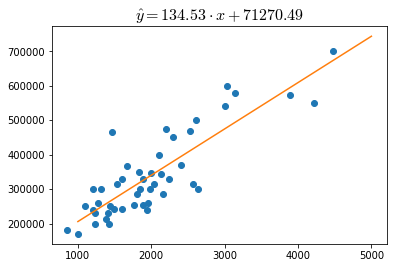

In [192]:
fig, ax = plt.subplots()
ax.plot(X_simple, y, ls='none', marker='o')
px = np.linspace(1000, 5000)
ax.plot(px, linreg.predict(px.reshape(-1, 1)))
ax.set_title(f'$\\hat{{y}}={linreg.coef_[0]:.2f} \cdot x '
             f'+ {linreg.intercept_:.2f}$', fontsize=16);

### Multiple Features
We can now introduce the dataset split step that we oversaw in the previous example. In `scikit-learn` splitting the dataset in train and test set is taken care of for us through a function. The proportion of the split can be configured through its arguments.

In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

We can now fit the all ($n=2$) features of the training set $X^t$

In [194]:
linreg = LinearRegression().fit(X_train, y_train)

Since this time $X^t \in \mathbb{R}^{m \times 2}$, we have 2 weight parameters and 1 bias parameter

In [195]:
linreg.coef_, linreg.intercept_

(array([  134.00624715, -6735.36295985]), 89300.92498337029)

Parameters fitted on the training set can be used to produce prediction from the test set features

In [196]:
y_pred = linreg.predict(X_test)
y_pred

array([627195.8048889 , 489472.43341908, 322331.5926185 , 235128.57632493,
       337107.33040746, 422469.30984317, 283504.83154673, 229902.332686  ,
       322366.64322076, 363908.57983783, 655704.08492997, 468532.40826114,
       411981.77196307, 325279.73005584, 190003.52163702, 328361.87374033])

Predictions can be now compared to the labels of the test set

In [197]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

0.7663988971402916

## Pytorch
Whereas `scikit-learn` is a high-level library, `Pytorch` is has a much lower-level approach. Many of the things that in `scikit-learn` happen under the hoods, in `Pytorch` need to be done manually. 

The main entry point of the framework is the `torch` module

In [198]:
import torch

The first noticeable Pytorch feature is that it works using a proprietary data-structure, called a `tensor`. The underlying mathematical concept of tensor is beyond the scope of this article but can be consulted at the [Wikipedia tensor entry](https://en.wikipedia.org/wiki/Tensor). In Pytorch, a `tensor` is (citing the [pytorch tensor documentation](https://pytorch.org/docs/stable/tensors.html)) *a multi-dimensional matrix containing elements of a single data type*.

In [199]:
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor[:5]

tensor([[2.1040e+03, 3.0000e+00],
        [1.6000e+03, 3.0000e+00],
        [2.4000e+03, 3.0000e+00],
        [1.4160e+03, 2.0000e+00],
        [3.0000e+03, 4.0000e+00]])

As you can notice we had to specify `dtype=np.float32`. This is because the underlying implementation of forward and backward propagation used by Pytorch under the hood would not work with the `int` type.

Furthermore, $y$ tensor would be 1D but this would not comply with requirements of Pytorch methods used below, so we transform it into a column vector with the `unsqueeze(-1)` method. This is equivalent to calling `.reshape(-1, 1)` on a `numpy.array`

In [200]:
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
y_tensor[:5]

tensor([[399900.],
        [329900.],
        [369000.],
        [232000.],
        [539900.]])

Since data is in very different scales we need to first normalize it. Here we use [standardization](https://en.wikipedia.org/wiki/Standard_score), which rescales data to have mean $\mu=0$ and standard deviation $\sigma=1$

$$
X_\text{std} = \frac{X - \mu}{\sigma}
$$

In [201]:
X_tensor_norm = (X_tensor - X_tensor.mean()) / torch.sqrt(X_tensor.var())
X_tensor_norm[:5]

tensor([[ 0.9590, -0.8692],
        [ 0.5204, -0.8692],
        [ 1.2166, -0.8692],
        [ 0.3603, -0.8701],
        [ 1.7387, -0.8684]])

A linear regression model can be built using the `Linear` class from the `nn` module, which initializes bias and weights automatically. Its constructor takes as input the number of columns of the input ($n_X$) and of the output ($n_y$)

In [202]:
model = torch.nn.Linear(2, 1)

Training the model will require some hyperparameters that we will define in advance for convenience:

* `epochs` is the number of times the model will see all of our training samples;
* `alpha` is the learning rate, which defines how big are the steps takes in updating the parameters;
* `loss_func` is the loss function $\mathcal{L}$ used at training time. In this case we are using the `MSELoss`, which measures the mean squared error (squared L2 norm) between each element in the input $x$ and target $y$;
* `optim` is the optimization algorithm used. In this case we are using `SGD` (Stochastic Gradient Descent). SGD requires us to select the correct $\alpha$. Up to this point we haven't seen that other optimization algorithm exist that automatically adapt $\alpha$ to data (e.g. [ADAM](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)), so we are sticking with standard SGD.

In [203]:
epochs = 10
alpha = 0.01
loss_func = torch.nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=alpha)

Now we need to manually run over the epochs and trigger the update of the parameters that will ultimately produce a fitted model

In [204]:
from torch.autograd import Variable

for epoch in range(epochs):
    inputs = Variable(X_tensor_norm)
    labels = Variable(y_tensor)
    # Clear gradient buffers because from previous epoch
    optim.zero_grad()
    # get output from the model, given the inputs
    outputs = model(inputs)
    # get loss for the predicted output
    loss = loss_func(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()
    # update parameters
    optim.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 131183001600.0
epoch 1, loss 117986418688.0
epoch 2, loss 106161872896.0
epoch 3, loss 95566716928.0
epoch 4, loss 86073106432.0
epoch 5, loss 77566492672.0
epoch 6, loss 69944254464.0
epoch 7, loss 63114424320.0
epoch 8, loss 56994619392.0
epoch 9, loss 51510988800.0


In [227]:
model(inputs)[:5]

tensor([[150347.2500],
        [124711.7578],
        [165403.0156],
        [115393.3906],
        [195880.8281]], grad_fn=<SliceBackward>)